## RNN for time series - exercise

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
Image(url= "https://cdn-images-1.medium.com/max/1600/1*UkI9za9zTR-HL8uM15Wmzw.png")

#### 1.Set up hyperparams

In [2]:
num_epochs = 10
total_series_length = 50000      
truncated_backprop_length = 15  ## sequence length 
state_size = 4                  ## number of neuros in hidden layer
num_classes = 2 
echo_step = 3                   ## how many steps you want to shift 
batch_size = 5
num_batches = total_series_length//(batch_size*truncated_backprop_length)  # number of batches


#### 2. generate some test data

In [3]:
def generateData(total_series_length):
    x = np.array(np.random.choice(2,total_series_length,p=[0.5,0.5]))  ## random choose 0 and 1 for 50000 times
    y = np.roll(x,echo_step)                          ## shift the data to the right by echo_steps 
    y[0:echo_step] = 0 
    x = x.reshape((batch_size,-1))                    ## make them into different batches 
    y= y.reshape((batch_size,-1))                     ## make them into different batches
    
    return (x,y)

In [4]:
data = generateData(total_series_length)
data

(array([[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 1, 0, 1],
        [1, 0, 0, ..., 1, 0, 0],
        [0, 1, 1, ..., 1, 0, 1],
        [1, 0, 0, ..., 1, 0, 0]]), array([[0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 1],
        [1, 0, 1, ..., 1, 0, 1],
        [1, 0, 0, ..., 1, 0, 1],
        [1, 0, 1, ..., 1, 1, 1]]))

#### 3. build model 

In [5]:

# input and output data
batchX_placeholder = tf.placeholder(tf.float32,[batch_size,truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32,[batch_size,truncated_backprop_length])

# this is RNN state 
init_state = tf.placeholder(tf.float32,[batch_size,state_size])

# weights and biases 1  
W = tf.Variable(np.random.rand(state_size+1,state_size),dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)),dtype=tf.float32)
# weights and biases 2  
W2 = tf.Variable(np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [6]:
batchX_placeholder.shape

TensorShape([Dimension(5), Dimension(15)])

In [7]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*n45uYnAfTDrBvG87J-poCA.jpeg")

In [8]:
## unpack batch matrix into 1 dimensional array
inputs_series = tf.unstack(batchX_placeholder, axis=1)   ## basically sliced each column into a sequence of arraies
labels_series = tf.unstack(batchY_placeholder, axis=1)   ## basically sliced each column into a sequence of arraies
# we do this because we need to feed data into rnn as sequence, 
# we feed in one column at a time 

In [9]:
## take a look at how our inputs get transformed
inputs_series

[<tf.Tensor 'unstack:0' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:1' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:2' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:3' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:4' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:5' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:6' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:7' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:8' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:9' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:10' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:11' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:12' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:13' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack:14' shape=(5,) dtype=float32>]

In [10]:
# Forward pass
# stat placeholder 

current_state = init_state
state_series = []

for current_input in inputs_series:
    current_input = tf.reshape(current_input,[batch_size,1])
    input_and_state_concatenated = tf.concat([current_input, current_state],1)
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)
    state_series.append(next_state)
    current_state = next_state

In [11]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*fdwNNJ5UOE3Sx0R_Cyfmyg.png")

In [12]:
## calculat loss and minimize it 
#second part of forward pass
#logits short for logistic transform
logits_series = [tf.matmul(state,W2) + b2 for state in state_series]
#apply softmax nonlinearity for output probability
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

# measure loss, calculate softmax again on logits, then compute cross entropy
# softmax cross entropy will apply softmax by it self
# here, our lables are not onehot encoded, we use sparse_softmax_cross_entropy
# if our lables are one hot encoded, we use softmax_cross_entropy
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for 
          logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

## optimizer 
## great paper http://seed.ucsd.edu/mediawiki/images/6/6a/Adagrad.pdf
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [13]:
###############
#visualizer
###############
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

#### 4. Train the network

New data, epoch 0
Step 0 Loss 0.761303
New data, epoch 1
Step 0 Loss 0.578917
New data, epoch 2
Step 0 Loss 0.120799
New data, epoch 3
Step 0 Loss 0.179847
New data, epoch 4
Step 0 Loss 0.161916
New data, epoch 5
Step 0 Loss 0.16888
New data, epoch 6
Step 0 Loss 0.192469
New data, epoch 7
Step 0 Loss 0.12838
New data, epoch 8
Step 0 Loss 0.118951
New data, epoch 9
Step 0 Loss 0.132007


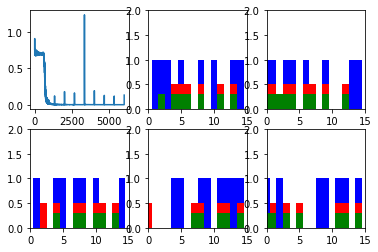

In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    #interactive mode
    plt.ion()
    #initialize the figure
    plt.figure()
    #show the graph
    plt.show()
    #to show the loss decrease
    loss_list = []

    for epoch_idx in range(num_epochs): ## loop through all batches
        x,y = generateData(total_series_length)
        _current_state = np.zeros((batch_size,state_size))  ## initial state, set to be all 0s 
                                                            ## it was a place holder, set up earlier before
        print("New data, epoch", epoch_idx)
        for batch_idx  in range(num_batches):
            #starting and ending point per batch
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length
            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]
            
            _total_loss,_train_step,_current_state,_predictions_series = sess.run(
                [total_loss,train_step,current_state,predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })
            
            loss_list.append(_total_loss)
            
            if batch_idx%1000 ==0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()